In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.dataloading import DataLoader
from src.preprocessing import Preprocesser
from src.lstm_vae import LSTMVAE

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


2023-12-18 16:20:14.662972: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
LATENT_DIM: int = 5

# Load Data

In [5]:
dataloader = DataLoader(path_to_data="../data/raw/P01")
df_list: list[pd.DataFrame] = dataloader.load_data()

2023-12-18 16:20:18,738 - src.dataloading - INFO - Found 10 .csv files in input path '../data/raw/P01' ...
2023-12-18 16:20:27,149 - src.dataloading - INFO - Parsed 10 .csv files into DataFrames ...


# Preprocess Data

In [6]:
preprocessor_train = Preprocesser(df_list=df_list, condition="MathxHard", rolling_window_size=250, fixed_size=10990)
tensor: np.array = preprocessor_train.preprocess_data()
FEATURE_NAMES = list(preprocessor_train.df_list_processed[0].columns)

print(tensor.shape)

2023-12-18 16:20:27,240 - src.preprocessing - INFO - Starting preprocessing pipeline (Condition: MathxHard, Window Size: 250, Fixed Size: 10990) ...
2023-12-18 16:20:27,428 - src.preprocessing - INFO - Stacking data to 3D tensor ...
2023-12-18 16:20:27,436 - src.preprocessing - INFO - Finished preprocessing pipeline (Duration: 0.19s) ...


(430, 250, 7)


# Modelling

In [13]:
vae = LSTMVAE(tensor=tensor, latent_dims=LATENT_DIM, reconstruction_weight=3)
vae.compile(optimizer="adam")
vae.build((None, tensor.shape[1], tensor.shape[2]))

AttributeError: 'LSTMVAE' object has no attribute 'sequence_length'

In [6]:
vae.encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 250, 7)]             0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 250, 128)             69632     ['input_1[0][0]']             
                                                                                                  
 lstm_1 (LSTM)               (None, 64)                   49408     ['lstm[0][0]']                
                                                                                                  
 z_mean (Dense)              (None, 5)                    325       ['lstm_1[0][0]']              
                                                                                            

In [7]:
vae.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 1)]            0         
                                                                 
 lstm_2 (LSTM)               (None, 5, 64)             16896     
                                                                 
 lstm_3 (LSTM)               (None, 128)               98816     
                                                                 
 Decode_1 (Dense)            (None, 1750)              225750    
                                                                 
 Decode_2 (Reshape)          (None, 250, 7)            0         
                                                                 
 lstm_4 (LSTM)               (None, 250, 7)            420       
                                                                 
 Decoder_Output_Layer (Time  (None, 250, 7)            56  

In [8]:
history = vae.fit(tensor, epochs=64, batch_size=4, validation_split=0.2, shuffle=True
                  #,callbacks=[ ReduceLROnPlateau(monitor="val_loss", patience=15), EarlyStopping(monitor="val_loss", patience=20)]
)

Epoch 1/64
86/86 [==============================] - 18s 135ms/step - loss: 566.0616 - reconstruction_loss: 99.6970 - kl_loss: 7.5926 - val_loss: 61.4185 - val_reconstruction_loss: 16.9689 - val_kl_loss: 10.5118 - lr: 0.0010
Epoch 2/64
86/86 [==============================] - 10s 113ms/step - loss: 61.2455 - reconstruction_loss: 18.4046 - kl_loss: 1.7099 - val_loss: 46.3648 - val_reconstruction_loss: 13.9723 - val_kl_loss: 4.4478 - lr: 0.0010
Epoch 3/64
86/86 [==============================] - 9s 107ms/step - loss: 50.0480 - reconstruction_loss: 16.0802 - kl_loss: 1.3759 - val_loss: 42.2652 - val_reconstruction_loss: 12.4701 - val_kl_loss: 4.8548 - lr: 0.0010
Epoch 4/64
86/86 [==============================] - 9s 108ms/step - loss: 47.7988 - reconstruction_loss: 15.7645 - kl_loss: 1.8710 - val_loss: 50.5628 - val_reconstruction_loss: 14.7882 - val_kl_loss: 6.1981 - lr: 0.0010
Epoch 5/64
86/86 [==============================] - 10s 112ms/step - loss: 47.5160 - reconstruction_loss: 15.486

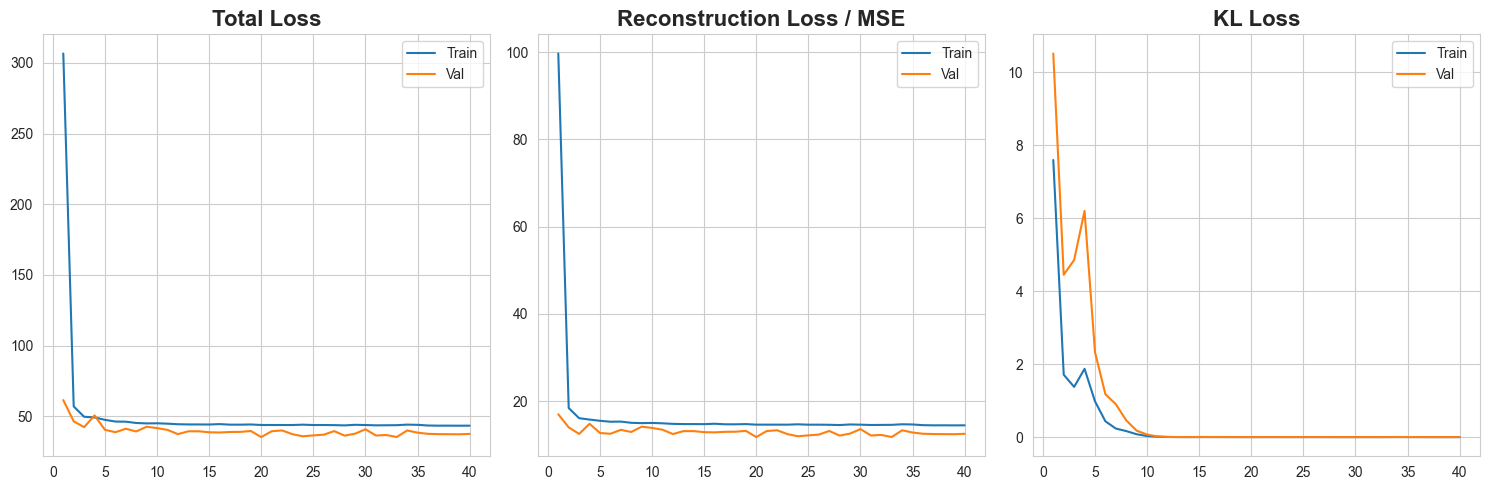

In [9]:
def plot_history(history):
    loss_dict = history.history

    loss_train = loss_dict["loss"]
    loss_val = loss_dict["val_loss"]

    rec_loss = loss_dict["reconstruction_loss"]
    rec_loss_val = loss_dict["val_reconstruction_loss"]

    kl_loss = loss_dict["kl_loss"]
    kl_loss_val = loss_dict["val_kl_loss"]

    x = [i+1 for i in range(0, len(loss_train))]

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    axes[0].set_title("Total Loss", size=16, fontweight="bold")
    sns.lineplot(x=x, y=loss_train, label="Train", ax=axes[0])
    sns.lineplot(x=x, y=loss_val, label="Val", ax=axes[0])

    axes[1].set_title("Reconstruction Loss / MSE", size=16, fontweight="bold")
    sns.lineplot(x=x, y=rec_loss, label="Train", ax=axes[1])
    sns.lineplot(x=x, y=rec_loss_val, label="Val", ax=axes[1])

    axes[2].set_title("KL Loss", size=16, fontweight="bold")
    sns.lineplot(x=x, y=kl_loss, label="Train", ax=axes[2])
    sns.lineplot(x=x, y=kl_loss_val, label="Val", ax=axes[2])
    fig.tight_layout()

plot_history(history)

## Save Model

In [10]:
#vae.save("../models/e64_b2_43k_params")

# Load Model
#vae = tf.keras.models.load_model("../models/e32-b1_final_dir")

# Reconstruction Plotting

In [11]:
train_sample = np.expand_dims(tensor[0], axis=0)
print(train_sample.shape)

(1, 250, 7)


In [12]:
train_sample_reconstructed = vae.predict(train_sample)

1/1 [==============================] - 2s 2s/step


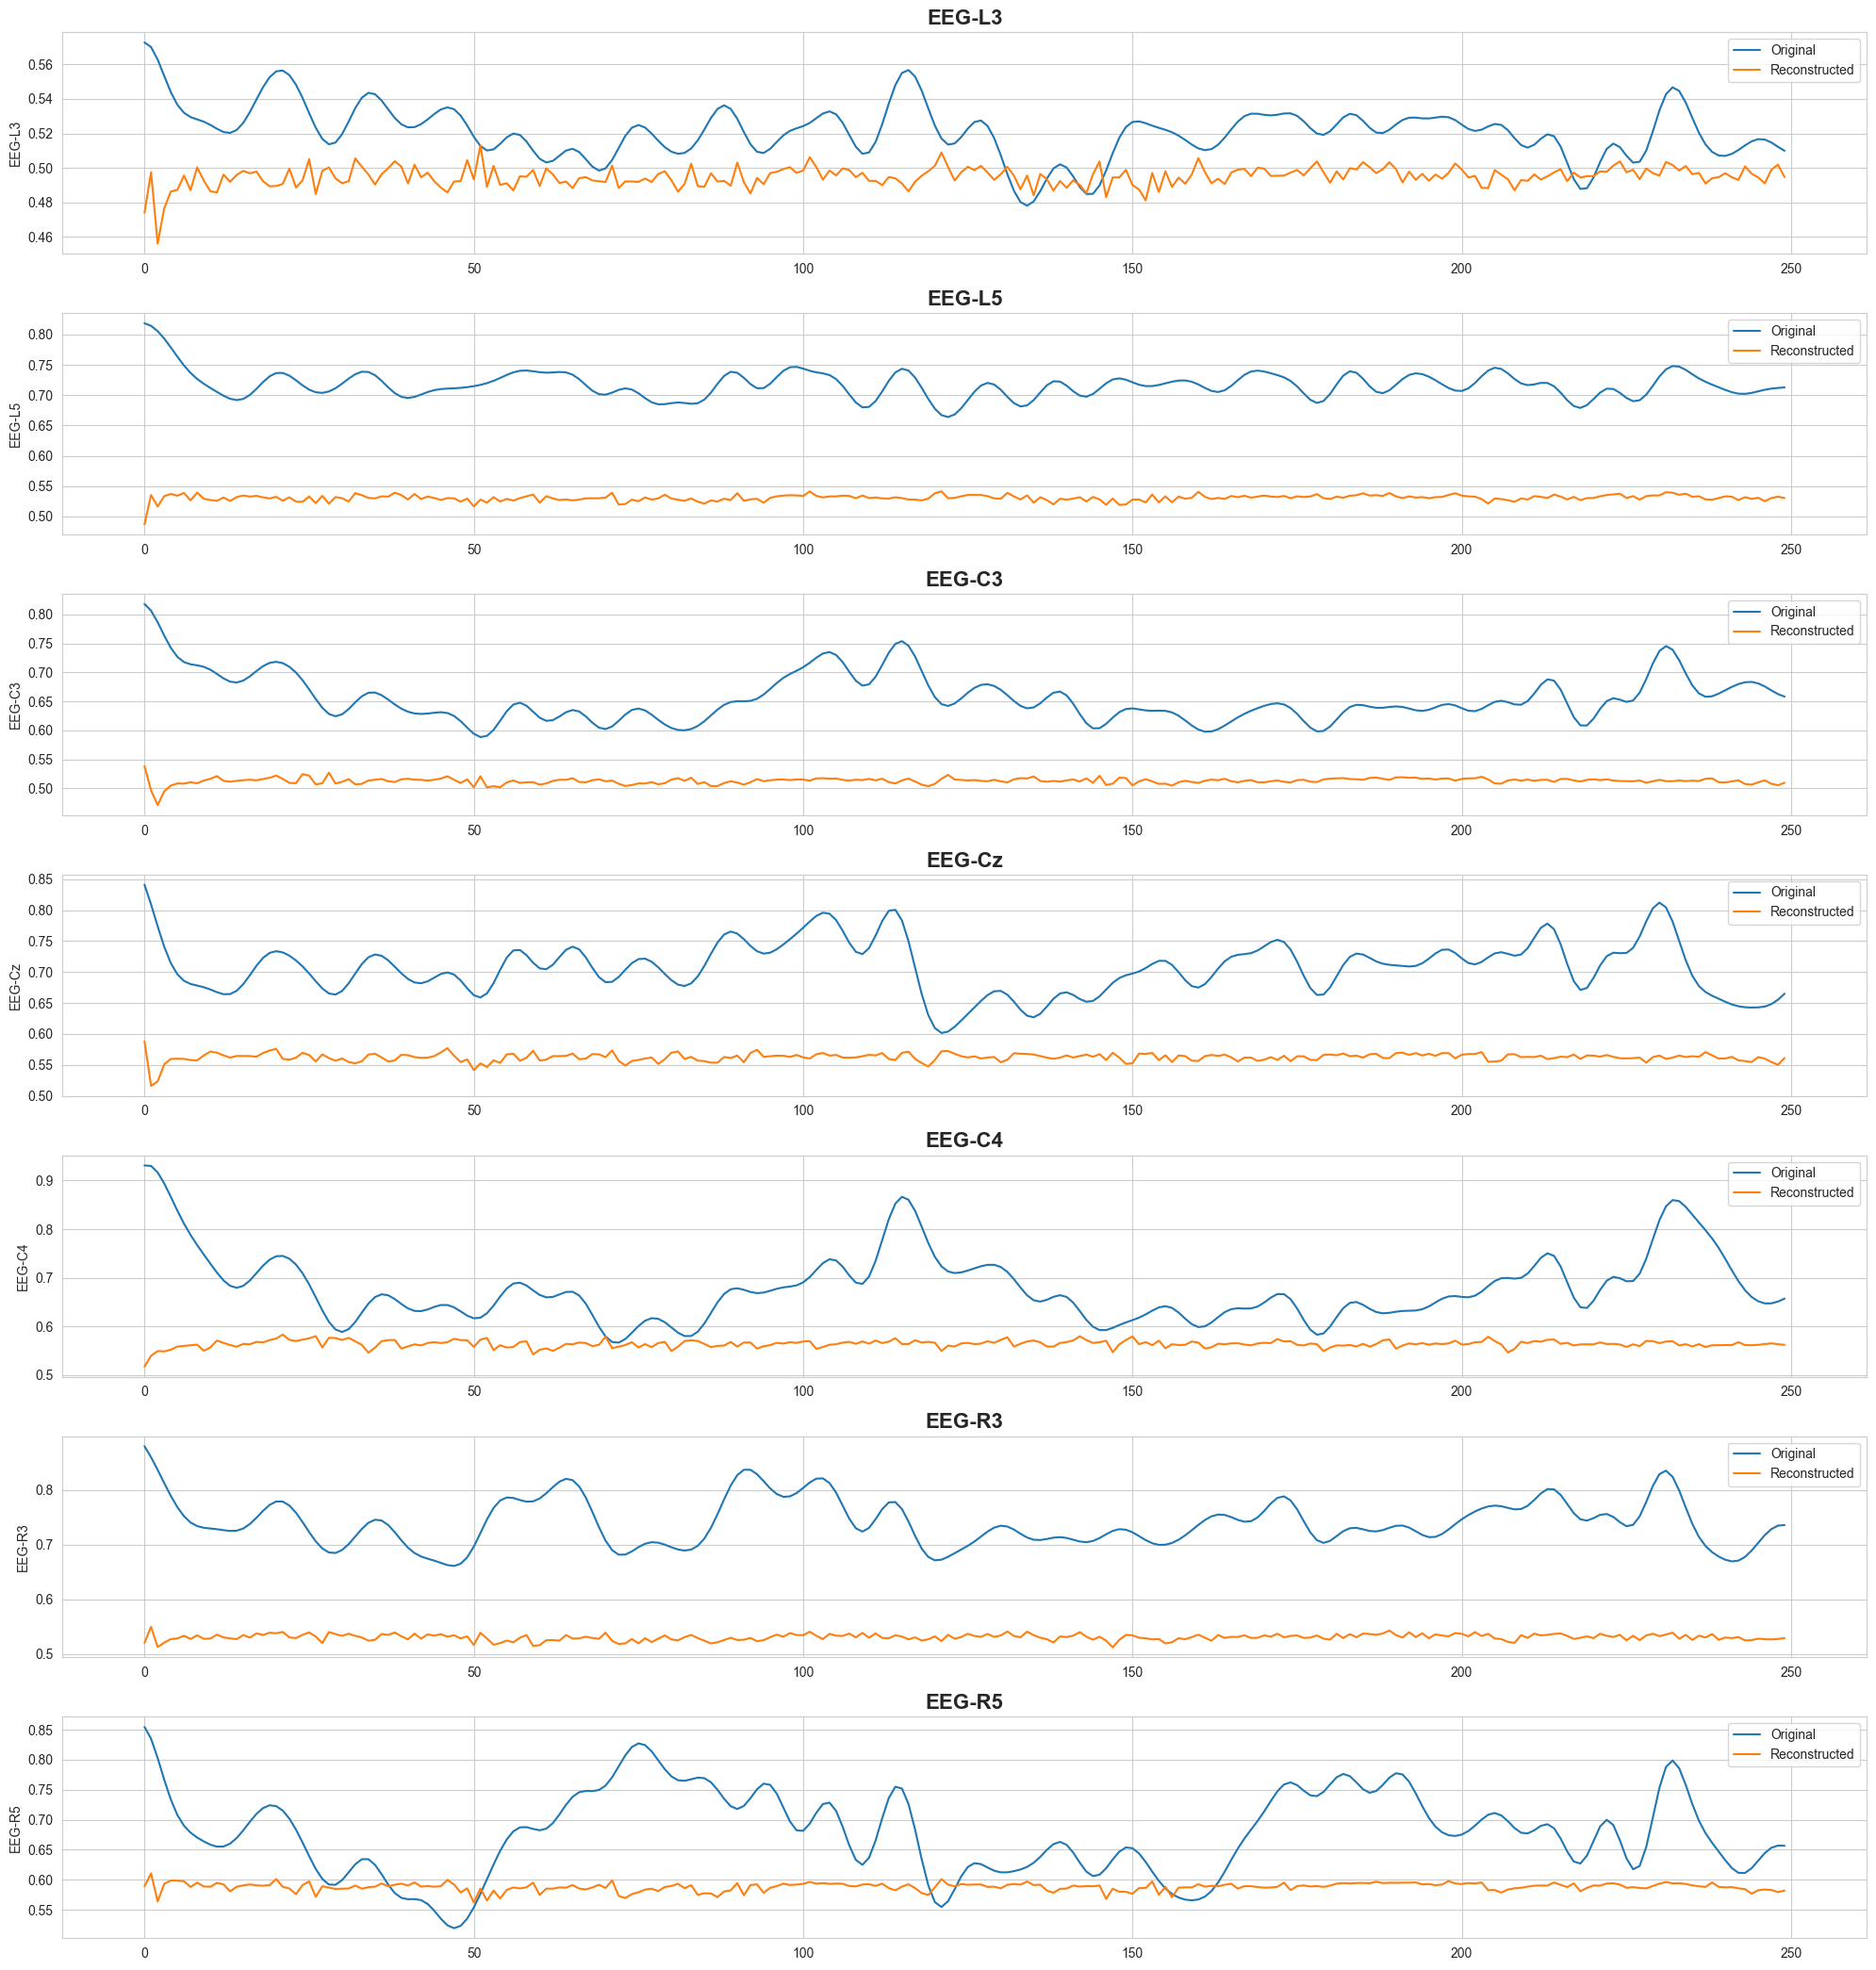

In [13]:
# Compare original and reconstruction
def compare_original_and_reconstruction(sample: np.array, sample_reconstructed: np.array) -> None:
    df_sample = pd.DataFrame(sample, columns=FEATURE_NAMES)
    df_reconstructed = pd.DataFrame(sample_reconstructed, columns=FEATURE_NAMES)

    fig, axes = plt.subplots(nrows=len(FEATURE_NAMES), ncols=1, figsize=(20, len(FEATURE_NAMES)*3))
    for col, ax in zip(FEATURE_NAMES, axes.flatten()):
        sns.lineplot(data=df_sample, x=df_sample.index, y=col, ax=ax, label="Original")
        sns.lineplot(data=df_reconstructed, x=df_reconstructed.index, y=col, ax=ax, label="Reconstructed")
        #ax.fill_between(df_reconstructed.index, df_sample[col], df_reconstructed[col], color='lightcoral', label="Error")
        ax.set_title(col, fontweight="bold", size=16)
    fig.tight_layout()


compare_original_and_reconstruction(train_sample[0], train_sample_reconstructed[0])

# Generate new Samples by Sampling from latent space

In [14]:
z_mean, z_log_var, z = vae.encoder.predict(tensor)

14/14 [==============================] - 1s 52ms/step


In [15]:
z.shape

(430, 5)

In [16]:
# Generate synthetic data function using the decoder part of the VAE
def generate_time_series_conditioned_on_x(x: np.array, num_samples: int, latent_dims: int):
    # Get mean and log_variance from encoding x
    z_mean, z_log_var, _ = vae.encoder.predict(x)
    # Sample from the latent space
    latent_samples = np.random.normal(size=(num_samples, latent_dims), loc=z_mean, scale=np.exp(z_log_var))
    print(f"Latent Samples: {latent_samples}")
    print("z_mean: ", z_mean)
    print("z_log_Var: ", z_log_var)
    # Generate synthetic data using the decoder model
    synthetic_data = vae.decoder(latent_samples).numpy()
    return synthetic_data

# Generate synthetic time series data
num_samples = 1
synthetic_time_series = generate_time_series_conditioned_on_x(train_sample, num_samples, latent_dims=LATENT_DIM)
print(synthetic_time_series.shape)

1/1 [==============================] - 0s 35ms/step
Latent Samples: [[-0.38574809  0.26420258 -0.68860056 -1.00953293  0.01415948]]
z_mean:  [[-2.8965073e-03 -3.1501045e-03 -5.8170408e-06  1.4066724e-03
  -5.7915784e-04]]
z_log_Var:  [[-0.00804747  0.00470135 -0.00285286 -0.00333251  0.00320655]]
(1, 250, 7)


In [17]:
test = synthetic_time_series[0]
test.shape

(250, 7)

In [18]:
test_df = pd.DataFrame(test, columns=FEATURE_NAMES)#, index=df_scaled_list[0].index)
test_df

,EEG-L3,EEG-L5,EEG-C3,EEG-Cz,EEG-C4,EEG-R3,EEG-R5
0,0.473885,0.486679,0.537912,0.587742,0.516369,0.519715,0.588519
1,0.495619,0.533839,0.494501,0.514626,0.537621,0.547400,0.608199
2,0.455542,0.515653,0.470593,0.523147,0.547630,0.511336,0.562855
3,0.476406,0.533143,0.494612,0.550533,0.546837,0.519486,0.592583
4,0.486258,0.536744,0.504560,0.559366,0.550193,0.526111,0.598114
...,...,...,...,...,...,...,...
245,0.494840,0.530586,0.510502,0.562539,0.560654,0.527350,0.582240
246,0.491288,0.525014,0.513768,0.560097,0.562536,0.526280,0.583424
247,0.498876,0.529931,0.507824,0.554536,0.564177,0.526048,0.582393
248,0.501738,0.532097,0.505427,0.550087,0.562511,0.526843,0.578959


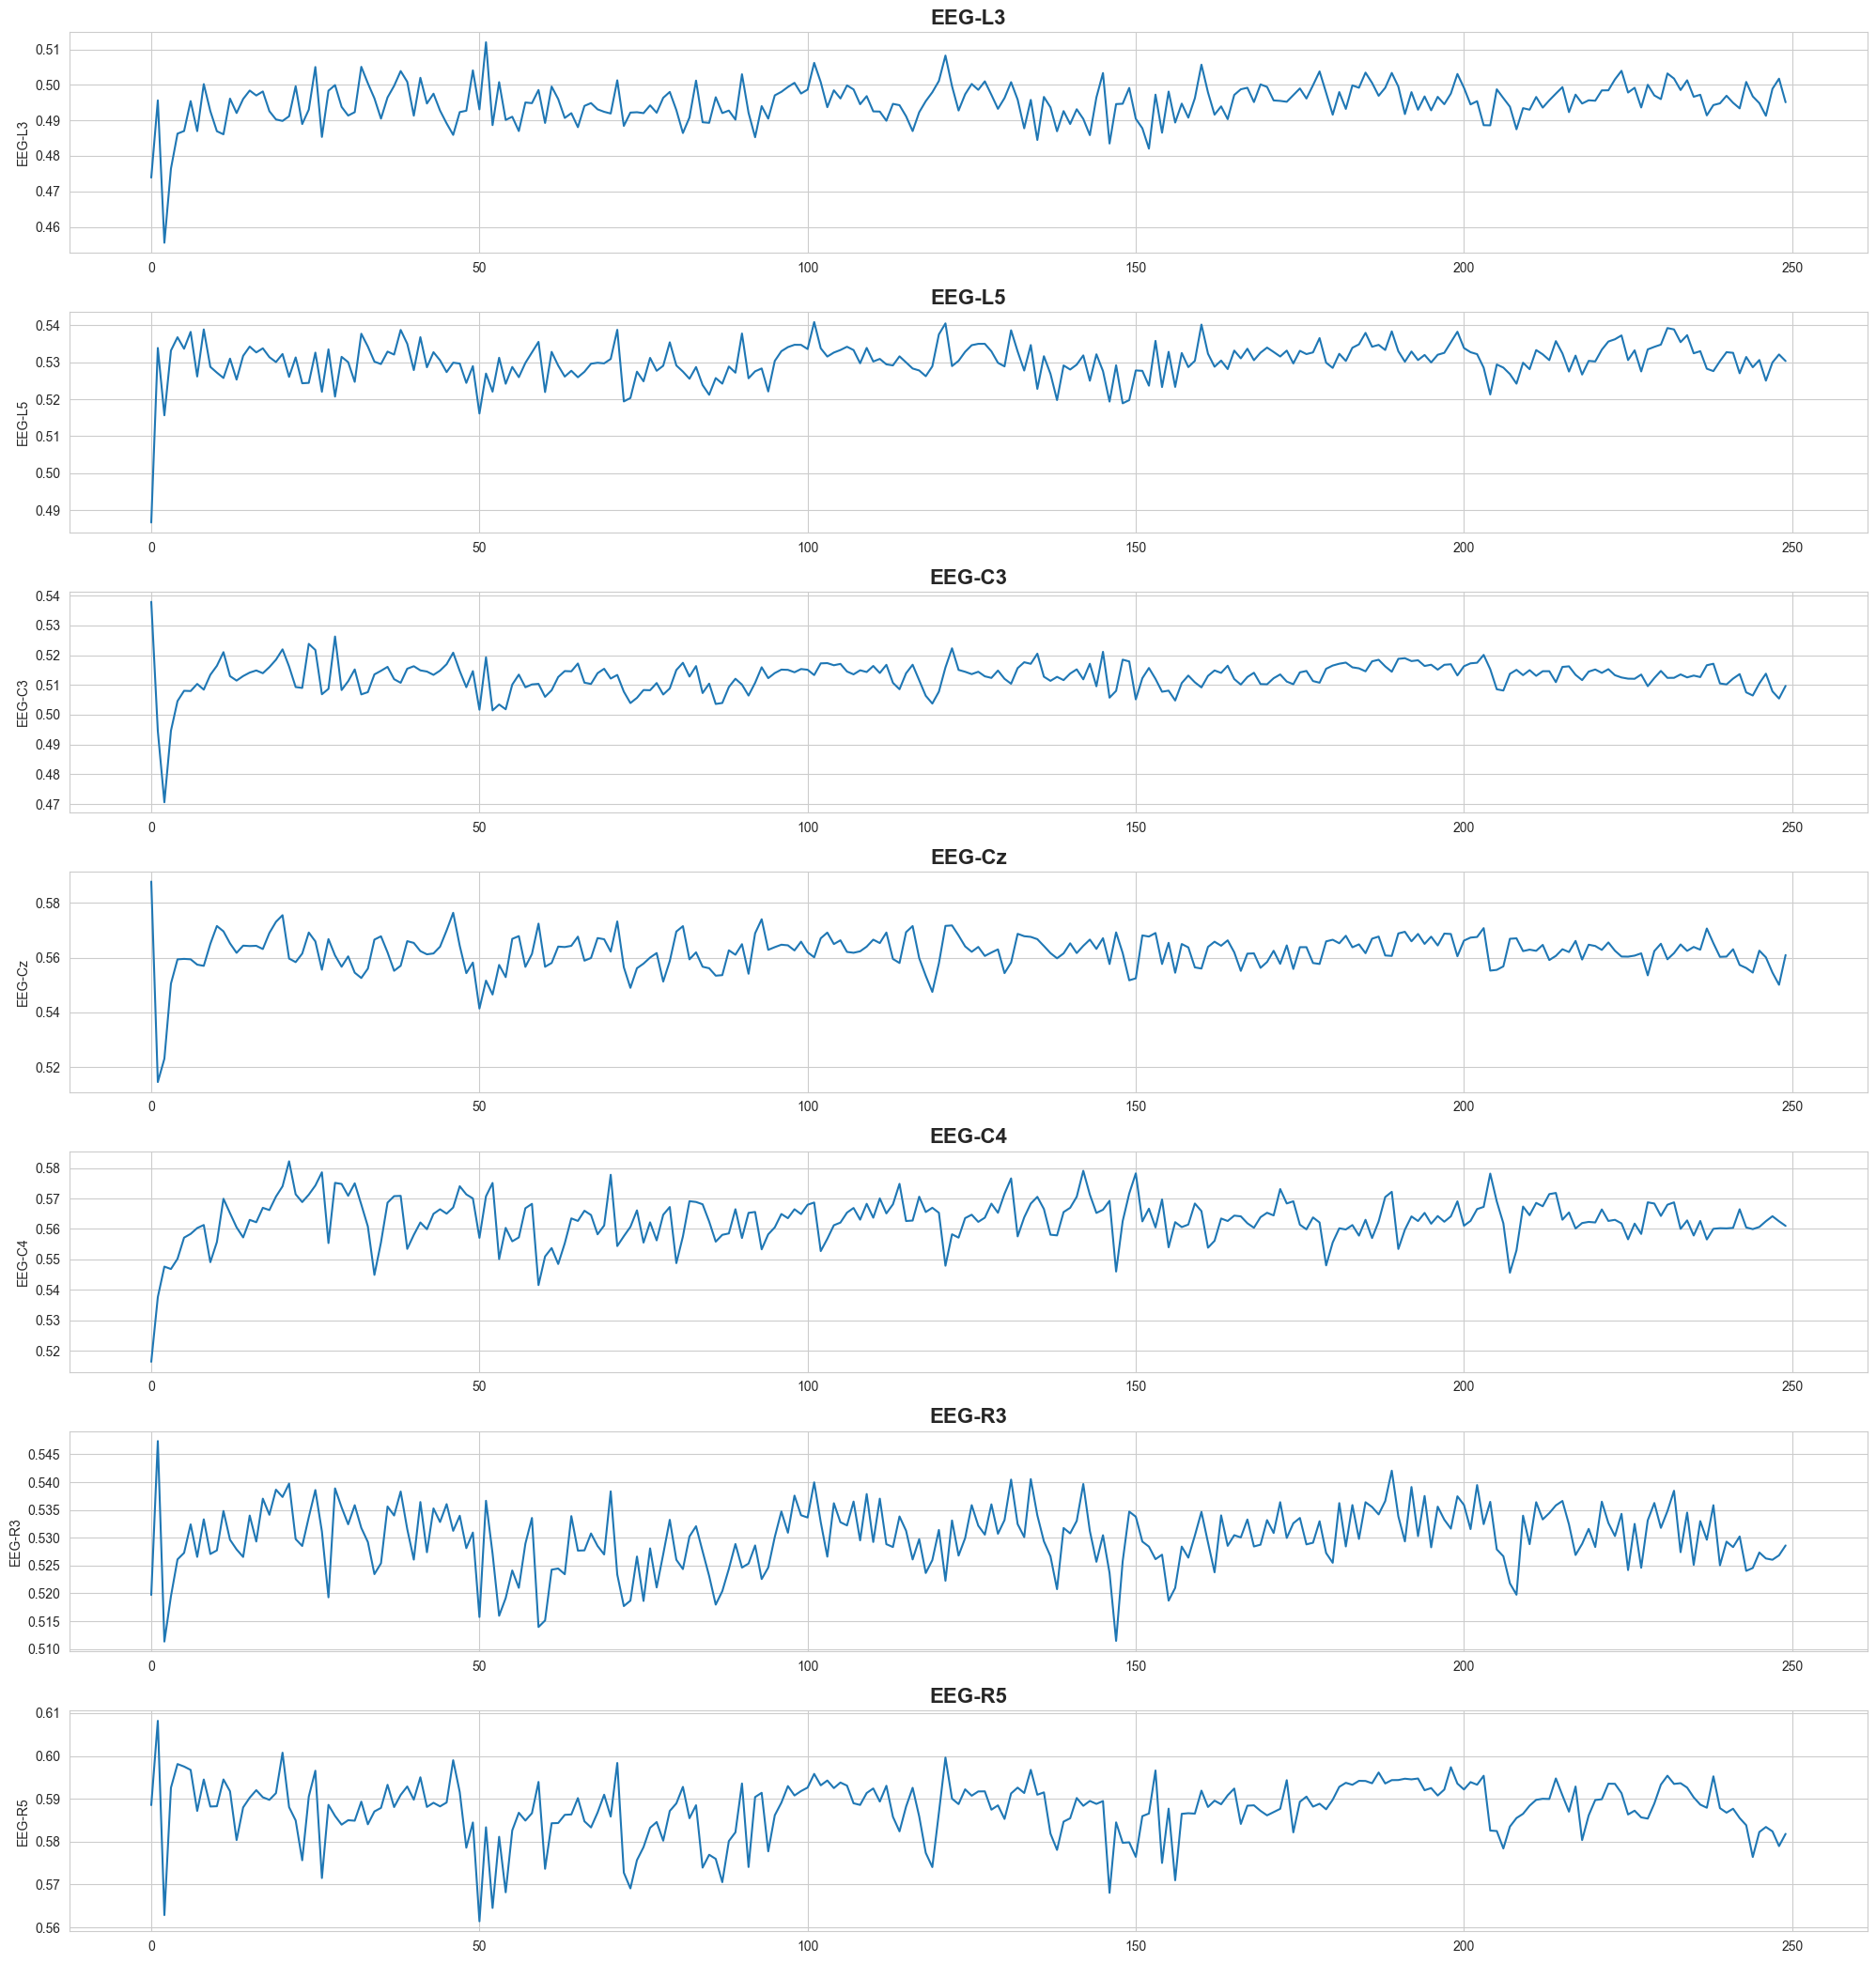

In [19]:
def plot_all_time_series(df: pd.DataFrame) -> None:
    """ Plots all Time Series (all float64 columns) in the provided DataFrame

    :param df: pd.DataFrame -- Input DataFrame
    :param time_col: str -- Name of the time column
    :return: None
    """
    cols = [x for x in list(df.columns) if x.startswith("EEG")]

    fig, axes = plt.subplots(nrows=len(cols), ncols=1, figsize=(20, len(cols)*3))
    for col, ax in zip(cols, axes.flatten()):
        sns.lineplot(data=df, x=df.index, y=col, ax=ax)
        ax.set_title(col, fontweight="bold", size=16)
    fig.tight_layout()

plot_all_time_series(test_df)